# 3. Model Inference (PKL) - Plank

**Objective:**
1. Load a specific trained pipeline (e.g., RandomForest from PKL).
2. Load and preprocess the raw test dataset using the same logic as in training.
3. Perform inference on the test data using the loaded pipeline.
4. Evaluate the model's performance with a detailed classification report and visualizations.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geometry_utils import GeometryUtils
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 3.1 Configure Paths and Model Selection

In [2]:
BASE_DATA_PATH = "../data/"
TEST_RAW_PATH = os.path.join(BASE_DATA_PATH, "test.csv")
MODEL_PKL_DIR = "../models/pkl/"

# >>>>> YOU CAN CHANGE THIS VALUE TO 'LR', 'KNN', 'DT', 'RF', or 'XGB' if you saved it earlier <<<<<
MODEL_TO_TEST = 'RF'

MODEL_PATH = os.path.join(MODEL_PKL_DIR, f"{MODEL_TO_TEST}_model.pkl")
print(f"Inference will be performed using model: {MODEL_PATH}")

Inference will be performed using model: ../models/pkl/RF_model.pkl


## 3.2 Load Model and Data

In [3]:
# Re-use the feature extraction logic from Notebook 2
VISIBILITY_THRESHOLD = 0.4
LANDMARK_NAMES = [ 'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer', 'right_eye_inner', 'right_eye', 'right_eye_outer', 'left_ear', 'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index', 'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle', 'left_heel', 'right_heel', 'left_foot_index', 'right_foot_index' ]
FEATURE_COLUMN_NAMES = [ 'left_elbow_angle', 'right_elbow_angle', 'left_shoulder_angle', 'right_shoulder_angle', 'left_hip_angle', 'right_hip_angle', 'left_knee_angle', 'right_knee_angle', 'left_body_align_angle', 'right_body_align_angle', 'left_hip_deviation', 'right_hip_deviation', 'shoulder_hip_y_diff_left', 'shoulder_hip_y_diff_right', 'hip_ankle_y_diff_left', 'hip_ankle_y_diff_right', 'torso_length_left', 'torso_length_right', 'leg_length_left', 'leg_length_right' ]
geo_utils = GeometryUtils()

def extract_features_from_row(row, landmark_names, visibility_threshold):
    lm_coords = {name: [row.get(f'{name}_x', np.nan), row.get(f'{name}_y', np.nan)] if row.get(f'{name}_v', 0) > visibility_threshold else [np.nan, np.nan] for name in landmark_names}
    def get_coord(name): return lm_coords.get(name, [np.nan, np.nan])
    features = [geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_elbow'), get_coord('left_wrist')), geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_elbow'), get_coord('right_wrist')), geo_utils.calculate_angle(get_coord('left_elbow'), get_coord('left_shoulder'), get_coord('left_hip')), geo_utils.calculate_angle(get_coord('right_elbow'), get_coord('right_shoulder'), get_coord('right_hip')), geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_knee')), geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_knee')), geo_utils.calculate_angle(get_coord('left_hip'), get_coord('left_knee'), get_coord('left_ankle')), geo_utils.calculate_angle(get_coord('right_hip'), get_coord('right_knee'), get_coord('right_ankle')), geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_ankle')), geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_ankle')), geo_utils.distance_point_to_line(get_coord('left_hip'), get_coord('left_shoulder'), get_coord('left_knee')), geo_utils.distance_point_to_line(get_coord('right_hip'), get_coord('right_shoulder'), get_coord('right_knee')), abs(get_coord('left_shoulder')[1] - get_coord('left_hip')[1]), abs(get_coord('right_shoulder')[1] - get_coord('right_hip')[1]), abs(get_coord('left_hip')[1] - get_coord('left_ankle')[1]), abs(get_coord('right_hip')[1] - get_coord('right_ankle')[1]), geo_utils.calculate_distance(get_coord('left_shoulder'), get_coord('left_hip')), geo_utils.calculate_distance(get_coord('right_shoulder'), get_coord('right_hip')), geo_utils.calculate_distance(get_coord('left_hip'), get_coord('left_ankle')), geo_utils.calculate_distance(get_coord('right_hip'), get_coord('right_ankle'))]
    return features

def process_raw_data_to_features(df_raw):
    feature_data = df_raw.apply(lambda row: extract_features_from_row(row, LANDMARK_NAMES, VISIBILITY_THRESHOLD), axis=1, result_type='expand')
    feature_data.columns = FEATURE_COLUMN_NAMES
    df_features = pd.concat([df_raw['label'], feature_data], axis=1)
    label_map = {"C": 0, "H": 1, "L": 2}
    df_features['label'] = df_features['label'].map(label_map)
    df_features.dropna(subset=['label'], inplace=True)
    df_features['label'] = df_features['label'].astype(int)
    return df_features

try:
    with open(MODEL_PATH, 'rb') as f:
        model_pipeline = pickle.load(f)
    print(f"Pipeline for model '{MODEL_TO_TEST}' loaded successfully.")
    print("Pipeline steps:", [step[0] for step in model_pipeline.steps])

    df_raw_test = pd.read_csv(TEST_RAW_PATH)
    df_test = process_raw_data_to_features(df_raw_test)
    
    X_test = df_test.drop('label', axis=1)
    y_test = df_test['label']
    print(f"Test data processed. Shape: X={X_test.shape}, y={y_test.shape}")
    
except FileNotFoundError:
    print(f"ERROR: Model file not found at {MODEL_PATH}. Make sure you ran Notebook 2 and saved the '{MODEL_TO_TEST}' model.")
    model_pipeline = None
    X_test, y_test = pd.DataFrame(), pd.Series()

Pipeline for model 'RF' loaded successfully.
Pipeline steps: ['imputer', 'model']
Test data processed. Shape: X=(710, 20), y=(710,)


## 3.3 Perform Inference and Evaluate

--- Performance Evaluation for RF Model ---
Accuracy: 0.9958

Classification Report:
               precision    recall  f1-score   support

  Correct (0)       0.99      1.00      0.99       234
Hips High (1)       1.00      1.00      1.00       241
 Hips Low (2)       1.00      0.99      1.00       235

     accuracy                           1.00       710
    macro avg       1.00      1.00      1.00       710
 weighted avg       1.00      1.00      1.00       710



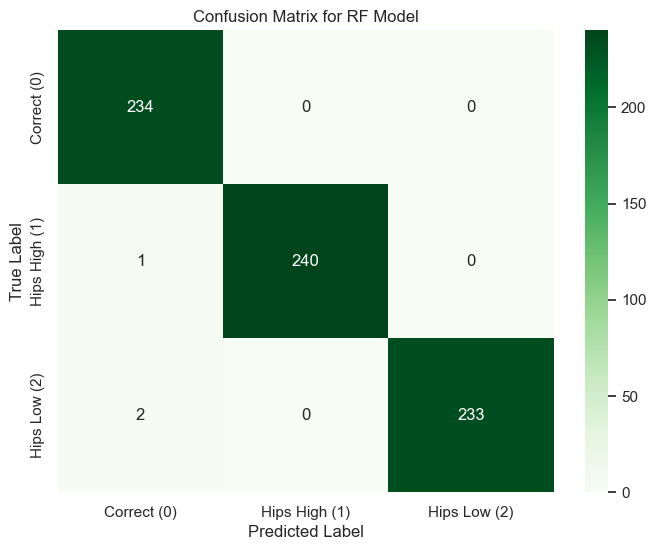

In [4]:
if model_pipeline and not X_test.empty:
    y_pred = model_pipeline.predict(X_test)
    y_pred_proba = model_pipeline.predict_proba(X_test)
    
    print(f"--- Performance Evaluation for {MODEL_TO_TEST} Model ---")
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    
    # Classification Report
    label_names = ['Correct (0)', 'Hips High (1)', 'Hips Low (2)']
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix for {MODEL_TO_TEST} Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Cannot perform inference. Model pipeline or test data not loaded.")